In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con = duckdb.connect(database=":memory:", read_only=False)

table = "cap4/legislators_terms.csv"
legislators = "cap4/legislators.csv"

<Axes: title={'center': 'Percent of Cohort Retained by Periods'}, xlabel='periods'>

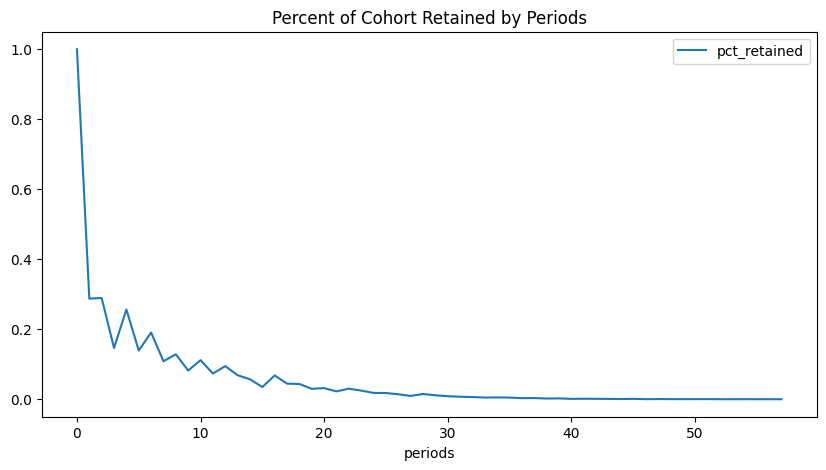

In [3]:
con.execute(
    f"""
with first_term as (
    
SELECT 
id_bioguide
,min(term_start) as first_term
FROM "{table}"
GROUP BY 1
),
cohorts_retained as (
    
SELECT date_part('year', age(b.term_start, a.first_term)) as periods
,count(distinct a.id_bioguide) as cohort_retained
FROM first_term a
JOIN "{table}" b on a.id_bioguide = b.id_bioguide 
GROUP BY 1
),
cohorts_pct_retained as (
    
select periods,
cohort_retained / first_value(cohort_retained) over (order by periods) as pct_retained
from cohorts_retained
)

select *
from cohorts_pct_retained

"""
).df().plot(
    x="periods",
    y="pct_retained",
    kind="line",
    figsize=(10, 5),
    title="Percent of Cohort Retained by Periods",
)

## Adjusting time series to increase retention accuracy

In [4]:
# pandas date dim table
date_range = pd.date_range(start="1789-12-31", end="2024-12-31", freq="Y")

date_dim = pd.DataFrame(date_range, columns=["date"])

<Axes: title={'center': 'Percent of Cohort Retained by Periods'}, xlabel='periods'>

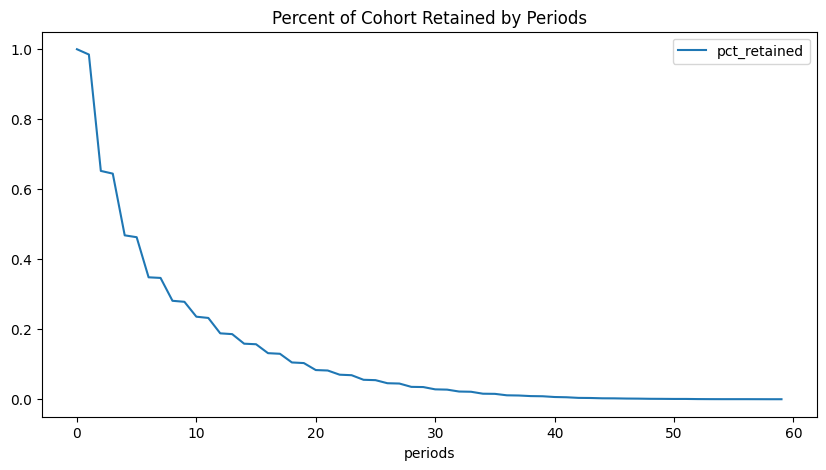

In [5]:
con.execute(
    f"""
WITH first_term AS (
    
SELECT id_bioguide,
min(term_start) AS first_term
FROM "{table}"
GROUP BY 1),

period_end_year AS (
    
SELECT a.id_bioguide,
a.first_term,
b.term_start,
b.term_end,
c.date,
date_part('year', age(c.date, a.first_term)) AS period
FROM first_term a
JOIN "{table}" b ON a.id_bioguide = b.id_bioguide
LEFT JOIN date_dim c ON c.date BETWEEN b.term_start AND b.term_end
AND date_part('month', c.date) = 12
AND date_part('day', c.date) = 31
),
cohort_retained_table as (
SELECT coalesce(period, 0) AS periods,
count(DISTINCT id_bioguide) AS cohort_retained
FROM period_end_year
GROUP BY 1
ORDER BY 1
)

select periods,
cohort_retained * 1.0 / first_value(cohort_retained) over (order by periods) as pct_retained
from cohort_retained_table
"""
).df().plot(
    x="periods",
    y="pct_retained",
    kind="line",
    figsize=(10, 5),
    title="Percent of Cohort Retained by Periods",
)

<Axes: title={'center': 'Percent of Cohort Retained by Periods'}, xlabel='periods'>

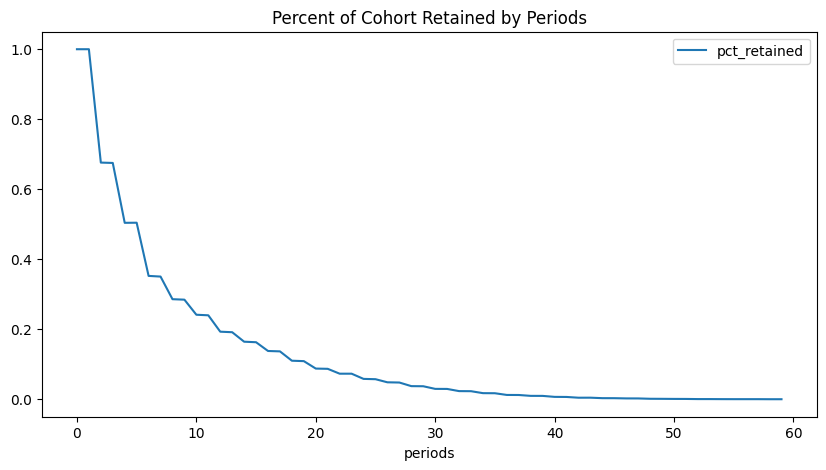

In [6]:
# do not have end date

con.execute(
    f""" 
with first_term as (
    SELECT id_bioguide,
    min(term_start) as first_term
    FROM "{table}"
    group by 1
),
start_and_end_year as (
    select a.id_bioguide, a.first_term,
    b.term_start,
    case when b.term_type = 'rep' then b.term_start + interval '2 years'
         when b.term_type = 'sen' then b.term_start + interval '6 years'
         end as term_end_date
    
    
    from first_term a
    join "{table}" b on a.id_bioguide = b.id_bioguide
),
period_end_year as (
    select 
    b.id_bioguide,
    date_part('year', age(c.date, b.first_term)) as period
    
    from start_and_end_year b
    left join date_dim c on c.date between b.term_start and b.term_end_date and date_part('day', c.date) = 31
    and date_part('month', c.date) = 12
    ),
cohort_retained_table as (
    SELECT coalesce(period, 0) AS periods,
    count(DISTINCT id_bioguide) AS cohort_retained
    FROM period_end_year
    GROUP BY 1
),
cohort_retained_pct as (
    select periods,
    cohort_retained * 1.0 / first_value(cohort_retained) over (order by periods) as pct_retained
    from cohort_retained_table
)


select *
from cohort_retained_pct
order by periods

"""
).df().plot(
    x="periods",
    y="pct_retained",
    kind="line",
    figsize=(10, 5),
    title="Percent of Cohort Retained by Periods",
)

In [7]:
century_retention = con.execute(
    f"""
WITH first_term AS (
    
    SELECT id_bioguide,
    min(term_start) AS first_term
    FROM "{table}"
    GROUP BY 1),

period_end_year AS (
    
    SELECT a.id_bioguide,
    a.first_term,
    b.term_start,
    b.term_end,
    c.date,
    date_part('year', age(c.date, a.first_term)) AS period
    FROM first_term a
    JOIN "{table}" b ON a.id_bioguide = b.id_bioguide
    LEFT JOIN date_dim c ON c.date BETWEEN b.term_start AND b.term_end
    AND date_part('month', c.date) = 12
    AND date_part('day', c.date) = 31
),
cohort_retained_table as (
    
    SELECT 
    date_part('century', first_term) as first_century,
    coalesce(period, 0) AS periods,
    count(DISTINCT id_bioguide) AS cohort_retained
    FROM period_end_year
    GROUP BY 1,2
),

cohort_retained_pct as (
    
    select 
    first_century,
    periods,
    first_value(cohort_retained) over (partition by first_century order by periods) as cohort_size,
    cohort_retained,
    cohort_retained  / first_value(cohort_retained) over (partition by first_century order by periods) as pct_retained
    from cohort_retained_table
)


select *
from cohort_retained_pct
"""
).df()  # .plot(x='periods', y='pct_retained', kind='line', figsize=(10, 5), title='Percent of Cohort Retained by Periods')

<Axes: xlabel='periods', ylabel='pct_retained'>

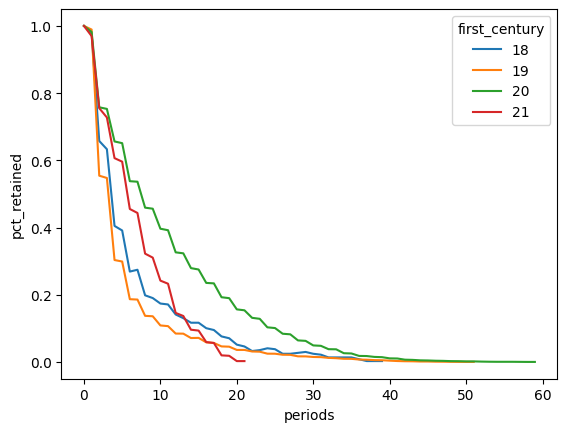

In [8]:
# century_retention


sns.lineplot(
    x="periods",
    y="pct_retained",
    hue="first_century",
    data=century_retention,
    palette="tab10",
)

In [9]:
# cohort by state


cohort_state = con.execute(
    f""" 
WITH first_term AS (
    
    SELECT distinct id_bioguide,
    min(term_start) over(partition by id_bioguide) AS first_term
    , first_value(state) over(partition by id_bioguide order by term_start) as first_state
    FROM "{table}"
),
period_end_year AS (
    
    SELECT 
    a.first_state,
    coalesce(date_part('year', age(c.date, a.first_term)), 0) AS period,
    count(distinct a.id_bioguide) as cohort_retained
    FROM first_term a
    JOIN "{table}" b ON a.id_bioguide = b.id_bioguide
    LEFT JOIN date_dim c ON c.date BETWEEN b.term_start AND b.term_end
    AND date_part('month', c.date) = 12
    AND date_part('day', c.date) = 31
    group by 1,2
),
cohort_retained_pct as (
    select 
    first_state,
    period,
    first_value(cohort_retained) over (partition by first_state order by period) as cohort_size,
    cohort_retained * 1.0 / first_value(cohort_retained) over (partition by first_state order by period) as pct_retained
    from period_end_year
)

-- get top 5 states with most cohortsize
select * from cohort_retained_pct
 where first_state in (select first_state from (
    select first_state, sum(distinct cohort_size)
    from cohort_retained_pct
    group by 1
    order by 2 desc
    limit 5
    ) a)
"""
).df()

<Axes: xlabel='period', ylabel='pct_retained'>

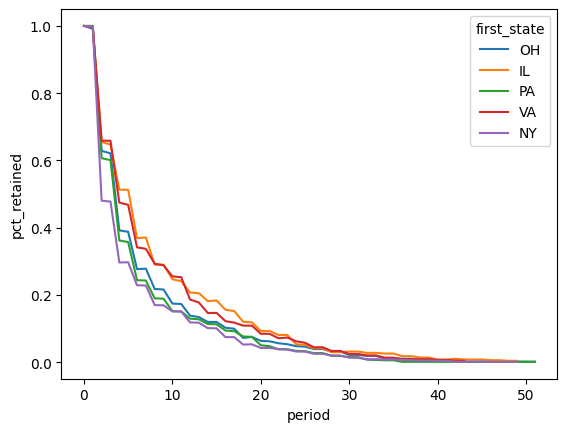

In [10]:
sns.lineplot(
    x="period", y="pct_retained", hue="first_state", data=cohort_state, palette="tab10"
)

## defining the cohort from a separate table

In [11]:
# gender from another table


cohort_gender = con.execute(
    f""" 
WITH first_term AS (
    
    SELECT id_bioguide,
    min(term_start) AS first_term
    FROM "{table}"
    group by 1
),
period_end_year AS (
    
    SELECT 
        d.gender,
        coalesce(date_part('year', age(c.date, a.first_term)), 0) AS period,
        count(distinct a.id_bioguide) as cohort_retained
    FROM first_term a
    JOIN "{table}" b ON a.id_bioguide = b.id_bioguide
    LEFT JOIN date_dim c ON c.date BETWEEN b.term_start AND b.term_end
        AND date_part('month', c.date) = 12
        AND date_part('day', c.date) = 31
    join "cap4/legislators.csv" d on a.id_bioguide = d.id_bioguide
    where a.first_term between '1917-01-01' and '1999-12-31'
    group by 1,2
),
cohort_percent as (
    
    from period_end_year
    select gender, period,
    first_value(cohort_retained) over(partition by gender order by period) as cohort_size,
    cohort_retained,
    cohort_retained / cohort_size as pct_retained
    
)


select * from cohort_percent

"""
).df()

<Axes: xlabel='period', ylabel='pct_retained'>

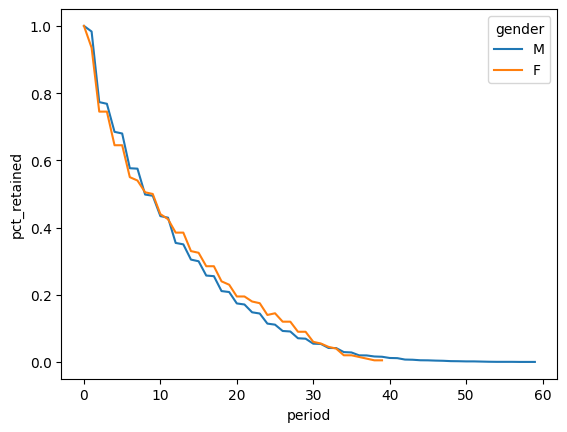

In [12]:
sns.lineplot(x="period", y="pct_retained", hue="gender", data=cohort_gender)

In [13]:
con.execute("CREATE TABLE my_table (index INTEGER, value INTEGER)")

# Insert data one line at a time
for i in range(21):
    con.execute(f"INSERT INTO my_table VALUES ({i}, {i * 2})")

# Query the table to see the result
con.execute("SELECT * FROM my_table").df()

,index,value
0,0,0
1,1,2
2,2,4
3,3,6
4,4,8
5,5,10
6,6,12
7,7,14
8,8,16
9,9,18


In [14]:
con.execute(
    f"""
with first_term_state as (
    select distinct id_bioguide
    ,min(term_start) over(partition by id_bioguide) as first_term
    ,first_value(state) over(partition by id_bioguide order by term_start) as first_state
    from "{table}"
),
gender_state as (select b.gender,
a.first_state,
count(distinct a.id_bioguide) as cohort_size
from first_term_state a
join "{legislators}" b on a.id_bioguide = b.id_bioguide
where a.first_term between '1917-01-01' and '1999-12-31'
group by 1,2)

select gender, first_state, index as period, cohort_size
from gender_state
join my_table on 1=1


"""
).df()

,gender,first_state,period,cohort_size
0,M,NC,0,93
1,M,PA,0,278
2,M,MD,0,66
3,M,WV,0,54
4,M,CA,0,224
...,...,...,...,...
2137,F,SD,20,2
2138,F,WY,20,1
2139,F,VI,20,1
2140,F,WV,20,1


In [15]:
year_2000_retention = con.execute(
    f""" 
SELECT 
    term_type
    ,period
    ,first_value(cohort_retained) over (partition by term_type order by period)  as cohort_size
    ,cohort_retained
    ,cohort_retained / first_value(cohort_retained) over (partition by term_type order by period) as pct_retained
FROM
(
    SELECT a.term_type
    ,coalesce(date_part('year',age(c.date,a.first_term)),0) as period
    ,count(distinct a.id_bioguide) as cohort_retained
    FROM
    (
        SELECT distinct id_bioguide
        , term_type
        ,make_date(2000,01,01) as first_term
        ,min(term_start) as min_start
        FROM "{table}" 
        WHERE term_start <= '2000-12-31' and term_end >= '2000-01-01'
        GROUP BY 1,2,3
    ) a
    JOIN "{table}"  b on a.id_bioguide = b.id_bioguide 
        and b.term_start >= a.min_start
    LEFT JOIN date_dim c on c.date between b.term_start and b.term_end 
        and date_part('month', c.date) = 12 and date_part('day', c.date) = 31 
        and date_part('year', c.date) >= 2000
    GROUP BY 1,2
    ) aa
    ;


"""
).df()

<Axes: xlabel='period', ylabel='pct_retained'>

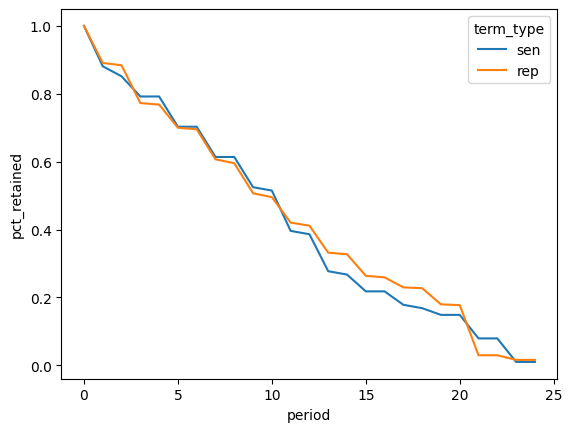

In [16]:
sns.lineplot(x="period", y="pct_retained", hue="term_type", data=year_2000_retention)

## Survivorship

In [17]:
con.execute(
    f""" 
select first_century,
count(distinct id_bioguide) as cohort_size,
count(distinct case when tenure >=10 then id_bioguide end) as survived_10,
survived_10 / cohort_size as pct_survived_10
from (
    SELECT id_bioguide,
    date_part('century', min(term_start)) as first_century,
    min(term_start) as first_term,
    max(term_end) as last_term,
    date_part('year', age(max(term_end), min(term_start))) as tenure,
    FROM "{table}" 
    group by 1
) a 
group by 1
;
"""
).df()  # .pipe((sns.lineplot, "data"), x='first_century', y='pct_survived_10', hue='first_century')

,first_century,cohort_size,survived_10,pct_survived_10
0,19,6299,1043,0.165582
1,20,5091,2226,0.437242
2,18,368,102,0.277174
3,21,760,190,0.250000


In [34]:
con.execute(
    f""" 
with num_terms as (
    SELECT  id_bioguide,
    min(term_start) as first_term,
    date_part('century', first_term) as first_century,
    max(term_end) as last_term,
    count(term_start) as n_terms

    FROM "{table}" 
    group by 1
)

select first_century,
count(distinct id_bioguide) as cohort_size,
count(distinct case when n_terms >= 5 then id_bioguide end) as survived_5_terms,
survived_5_terms / cohort_size as pct_survived
from num_terms
group by 1
order by 1

"""
).df()

,first_century,cohort_size,survived_5_terms,pct_survived
0,18,368,63,0.171196
1,19,6299,711,0.112875
2,20,5091,2153,0.422903
3,21,760,205,0.269737


# survivorship per century and term

<Axes: xlabel='terms', ylabel='pct_survived'>

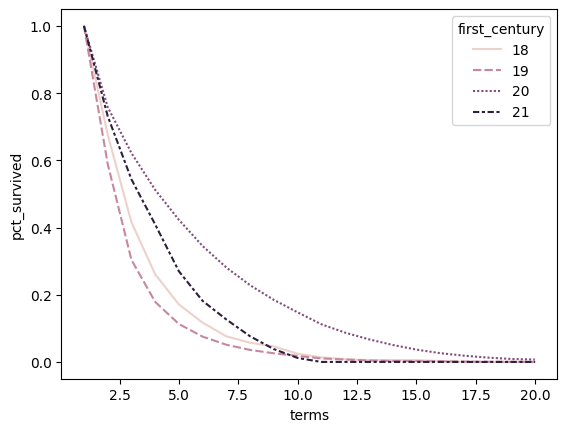

In [45]:
custom_palette = {
    "first_century": [
        "--",
        "-.",
        ":",
        "-",
        "--",
        "-.",
        ":",
        "-",
        "--",
        "-.",
        ":",
        "-",
        "--",
        "-.",
        ":",
        "-",
    ],
}


con.execute(
    f""" 
with num_terms as (
    SELECT  id_bioguide,
    min(term_start) as first_term,
    date_part('century', first_term) as first_century,
    max(term_end) as last_term,
    count(term_start) as n_terms

    FROM "{table}" 
    group by 1
)

select a.first_century, b.terms,
count(distinct a.id_bioguide) as cohort_size,
count(distinct case when a.n_terms >= b.terms then id_bioguide end) as cohort_survived,
cohort_survived / cohort_size as pct_survived
from num_terms a
join (
    SELECT generate_series AS terms
    FROM generate_series(1, 20, 1)
) b on 1=1
group by 1,2
order by 1,2

"""
).df().pipe(
    (sns.lineplot, "data"),
    x="terms",
    y="pct_survived",
    hue="first_century",
    style="first_century",
)

# Retention or Repeat purchase behavior

In [48]:
table

'cap4/legislators_terms.csv'

In [76]:
con.execute(
    f""" 
with rep_term_start  as (
    SELECT id_bioguide,
    min(term_start) as first_term 
    FROM "{table}" 
    where term_type='rep'
    group by 1
),
century_reps as (
    select date_part('century', first_term)::int cohort_century,
    count(distinct id_bioguide) as n_reps
    from rep_term_start
    where first_term <= '2009-12-31'
    group by 1
),
century_reps_as_sen as (
    select date_part('century', first_term)::int as cohort_century,
    count(distinct a.id_bioguide) as reps_and_sen
    from rep_term_start a
    join "{table}" b
        on b.term_type = 'sen'
        and a.id_bioguide = b.id_bioguide
        and b.term_start > a.first_term
    where age(b.term_start, a.first_term) <= interval '10 years'
    group by 1
)

select century_reps_as_sen.cohort_century,
    reps_and_sen / n_reps as pct_reps_and_sen
from century_reps_as_sen
left join century_reps
    on century_reps_as_sen.cohort_century = century_reps.cohort_century
;
"""
).df()  # .set_index("cohort_century").sort_index().plot()

,cohort_century,pct_reps_and_sen
0,19,0.024424
1,20,0.034814
2,18,0.096990
3,21,0.076364


# cumulative calculations

In [79]:
con.execute(
    f""" 
with first_term_buiguide as (
    SELECT id_bioguide,
    min(term_start) as first_term
    FROM "{table}" 
    group by 1
)

select *
from first_term_buiguide


"""
).df()

,id_bioguide,first_term
0,B000944,1993-01-05
1,C000127,1993-01-05
2,C000141,1987-01-06
3,C000174,1983-01-03
4,C001070,2007-01-04
...,...,...
12513,B000169,1995-01-04
12514,N000185,2011-01-05
12515,D000609,2009-01-06
12516,B001241,2003-01-07


In [2]:
def count_characters(text):
    character_count = {}
    text = text.replace(" ", "").replace("\n", "")

    for char in text:
        if char in character_count:
            character_count[char] += 1
        else:
            character_count[char] = 1

    # Ordenar o dicionário por contagem (decrescente) e, em caso de empate, por caractere (crescente)
    sorted_characters = sorted(
        character_count.items(), key=lambda item: (-item[1], item[0])
    )

    for char, count in sorted_characters:
        print(f"{char} {count}")

    print("-1")


# Ler o número de testes
num_tests = int(input())


text = []
for _ in range(num_tests):
    text.append(input())


for t in text:
    count_characters(t)

f 1
i 1
n 1
o 1
-1
a 1
f 1
i 1
l 1
-1
